# REINFORCE Tutorial

Tutorial network to construct pipeline to train and test REINFORCE agent. The agent has been trained and tested on gymnasium environments. 

## REINFORCE
- Model-free
- Policy-based
- On-policy

## Tasks
- CartPole-v1

## Environment

In this notebook, we use CarPole-v1 environment from gymnasium. 

In [77]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from gymnasium.spaces import Discrete, Box
from tqdm import tqdm
from collections import namedtuple
from datetime import datetime
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal

# define environment (editable)
envname = "CartPole-v1"
env = gym.make(envname)

# plot settings
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
  from IPython import display

# device setting (cpu or cuda!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda


## Hyperparameters

- `NUM_EPISODES`: number of training episodes. 
- `TEST_EPISODES`: number of test episodes during training. 
- `TEST_FREQ`: testing frequency. 
- `GAMMA`: discount factor when calculating estimated goal. 
- `LR`: learning rate. 

In [78]:
HyperParameter = namedtuple("HyperParameter", (
  "NUM_EPISODES",
  "TEST_EPISODES",
  "TEST_FREQ",
  "GAMMA",
  "LR"
))

# editable
hp = HyperParameter(
  NUM_EPISODES=600,
  TEST_EPISODES=5,
  TEST_FREQ=100,
  GAMMA=0.99,
  LR=0.0005
)

## Policy Network

In this notebook, we use simple environment that have some real numbers as observations and (1) few discrete actions or (2) one continuous action. So, we use simple fully-connected network. 

In [79]:
class SimplePolicyNetwork(nn.Module):
  """
  Fully-connected policy network. 
  """
  def __init__(self, dim_observation: tuple, action_space: Discrete | Box):
    """
    n_observations input channels and n_actions output channels. 
    """
    super(SimplePolicyNetwork, self).__init__()
    assert len(dim_observation) == 1
    
    # feature extraction
    self.seqmodel = nn.Sequential(
      nn.Linear(dim_observation[0], 128), 
      nn.ReLU(),
      nn.Linear(128, 128), 
      nn.ReLU(),
    )
    
    # action can be discrete or continuous
    self.discrete_action = isinstance(action_space, Discrete)
    if self.discrete_action:
      # discrete action: softmax output
      self.action_prob = nn.Sequential(
        nn.Linear(128, action_space.n), 
        nn.Softmax(dim=-1)
      )
    else:
      # continuous action: vector of float
      assert len(action_space.shape) == 1
      self.mean = nn.Linear(128, action_space.shape[0])
      self.log_std = nn.Linear(128, action_space.shape[0])

  def forward(self, x: torch.Tensor):
    """
    Forward with relu activation. 
    """
    x = self.seqmodel(x)
    if self.discrete_action:
      # discrete action
      return self.action_prob(x)
    else:
      # continuous action
      mean = self.mean(x)
      log_std = self.log_std(x)
      log_std = torch.clamp(log_std, min=-20, max=2)
      std = torch.exp(log_std)
      return mean, std

## Training: Utility Functions

- `select_action`: select agent's action using policy network. 
- `save_plot`: plot objective func, average frames, and score. 
- `save_model`: store model, hyperparameters, and training info. 

In [80]:
# policy network
dim_observation = env.observation_space.shape
action_space = env.action_space
discrete_action = isinstance(env.action_space, Discrete)

policy_net = SimplePolicyNetwork(dim_observation, action_space).to(device)

# adamw optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=hp.LR, amsgrad=True)

# save directory
start_datetime = datetime.now()
dirname = start_datetime.strftime("%Y%m%d-%H%M%S")
path = os.path.join(os.getcwd(), "reinforce_tutorial", dirname)

# training variables
train_objectives = []
train_frames = []
train_scores = []
test_frames = []
test_scores = []
steps = 0

def select_action(state: np.ndarray):
  """
  Select agent's action using policy network. 
  Don't use torch.no_grad() because REINFORCE is on-policy. 
  """
  assert state.shape[0] == 1
  if discrete_action:
    # get probabilities for each action
    probs = policy_net(state)
    # sample one action
    dist = Categorical(probs)
    action = dist.sample()
    # return with log probabilities
    return action.item(), dist.log_prob(action)
  else:
    # get mean and std
    mean, std = policy_net(state)
    # sample action from normal distribution (squeeze to [-1, 1])
    dist = Normal(mean, std)
    action = dist.sample()
    action = torch.tanh(action)
    # return with log probabilities
    return action[0].cpu().numpy(), torch.sum(dist.log_prob(action), dim=-1, keepdim=False)

def save_plot():
  """
  Plot objective func, average frames, and score and save the figures. 
  """
  plt.figure(figsize=(16, 12))
  plt.clf()
  plt.ion()
  
  plt.subplot(2, 2, 1)
  plt.title("")
  plt.xlabel("")
  plt.ylabel("")
  plt.legend()
  plt.grid()
  
  plt.subplot(2, 2, 2)
  plt.title("J(θ)")
  plt.xlabel("Episode")
  plt.ylabel("J(θ)")
  plt.plot(*zip(*train_objectives), label="train")
  if len(train_objectives) >= 100:
    x, y = zip(*train_objectives)
    y = torch.mean(torch.tensor(y).unfold(0, 100, 1), dim=1)
    plt.plot(x[99:], y, label="train-avg100")
  plt.legend()
  plt.grid()
  
  plt.subplot(2, 2, 3)
  plt.title("# of Frames")
  plt.xlabel("Episode")
  plt.ylabel("# of Frames")
  plt.plot(*zip(*train_frames), label="train")
  plt.plot(*zip(*test_frames), label="test")
  plt.legend()
  plt.grid()
  
  plt.subplot(2, 2, 4)
  plt.title("Score")
  plt.xlabel("Episode")
  plt.ylabel("Score")
  plt.plot(*zip(*train_scores), label="train")
  plt.plot(*zip(*test_scores), label="test")
  plt.legend()
  plt.grid()
  
  plt.ioff()
  plt.savefig(os.path.join(path, "plot.png"))
  
  if is_ipython:
    display.clear_output(wait=True)
    display.display(plt.gcf())

def save_model():
  """
  Save model, hyperparameters, and training info.
  """
  # save model
  torch.save({
    "policy_net": policy_net.state_dict()
  }, os.path.join(path, "model.pt"))
  
  # save hyperparameters
  with open(os.path.join(path, "hparam.json"), "w") as w:
    json.dump(hp._asdict(), w, indent=2)
  
  # save training info
  with open(os.path.join(path, "info.json"), "w") as w:
    json.dump(dict([
      ("env", envname), 
      ("test_frames", test_frames), 
      ("test_scores", test_scores), 
      ("steps", steps), 
      ("training_time", (datetime.now() - start_datetime).seconds)
    ]), w, indent=2)

## Training: Testing Function

- `test_model`: run policy model in the environment with trained policy network. 

In [81]:
def test_model():
  """
  Test policy model and return the result in training variables. 
  """
  # testing variables
  frames = []
  scores = []
  
  # repeat for TEST_EPISODES episodes
  for _ in range(1, hp.TEST_EPISODES + 1):
    # initialize environment and state
    state, _ = env.reset()
    state = torch.tensor(np.array(state), device=device, dtype=torch.float32).unsqueeze(0)
    score = 0
    
    # start an episode
    for frame in count():
      # select action
      with torch.no_grad():
        action, _ = select_action(state)
      
      # act to next state
      observation, reward, terminated, truncated, _ = env.step(action)
      score += reward
      done = terminated or truncated
      
      # update state
      state = torch.tensor(np.array(observation), device=device, dtype=torch.float32).unsqueeze(0)

      # check end condition
      if done:
        frames.append(frame)
        scores.append(score)
        break
      
  # add to training variables
  return np.mean(np.array(frames)), np.mean(np.array(scores))

## Training

In training, simulate agent in the environment to create trajectory, and trains policy network. 

Object of REINFORCE algorithm is maximizing objective function, which is defined as below. 

$$
\begin{gather}
J_i(\theta_i) = E_{s0 \sim p0} \left[ v_{\pi_{\theta_i}}(s_0) \right] = E_{\tau \sim \pi_\theta} \left[ G(\tau) \right] \notag \\
\text{where } \tau = S_0, A_0, R_0, S_1, ..., S_{T-1}, A_{T-1}, R_{T-1}, S_T \notag \\
\text{where } G(\tau) = R_1 + \gamma R_2 + ... + \gamma^{T-1} R_T \notag
\end{gather}
$$

We can get objective function using some mathematical tricks. 

$$
\begin{aligned}
\nabla_\theta J(\theta) &= \nabla_\theta E_{\tau \sim \pi_\theta} \left[ G(\tau) \right] \\ 
&= E_{\tau \sim \pi_\theta} \left[ \nabla_\theta \ln p(\tau|\pi_\theta) G(\tau) \right] \\ 
&= E_{\tau \sim \pi_\theta} \left[ G(\tau) \sum_{t=0}^T \nabla_\theta \ln \pi(A_t|S_t;\pi_\theta) \right] \\ 
&= E_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T \gamma^t R_t \sum_{t=0}^T \nabla_\theta \ln \pi(A_t|S_t;\pi_\theta) \right] \\
&= E_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T \left( \left( \sum_{k=t}^{T-1} \gamma^k R_k \right) \nabla_\theta \ln \pi(A_t|S_t;\pi_\theta) \right) \right] 
\end{aligned}
$$

In this point, we approximate $ \gamma $-included term to prevent reward vanishing. 

$$
\begin{gather}
\sum_{k=t}^{T-1} \gamma^k R_k 
= \gamma^t \sum_{k=t}^{T-1}  \gamma^{k-t} R_k 
= \gamma^t G_t
\cong G_t \notag \\
\nabla_\theta J(\theta) 
\cong E_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T G_t \nabla_\theta \ln \pi(A_t|S_t;\pi_\theta) \right] \notag
\end{gather}
$$

So, we update parameters as below. 

$$
\theta \leftarrow \theta + \alpha \sum_{t=0}^T G_t \nabla_\theta \ln \pi(A_t|S_t;\pi_\theta)
$$

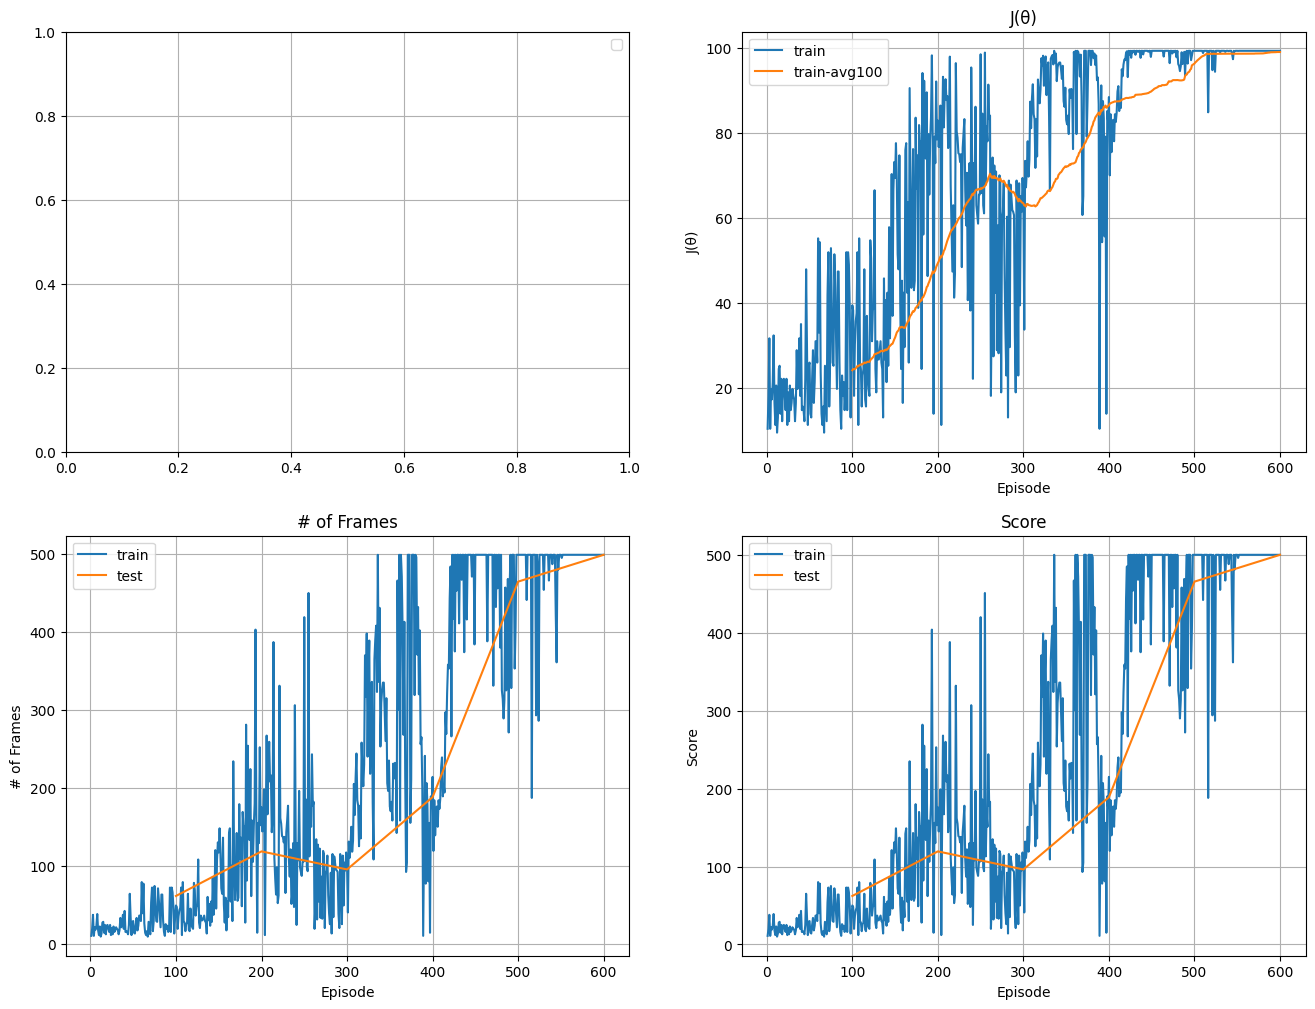

In [82]:
# create training directory
os.makedirs(path)

for episode in tqdm(range(1, hp.NUM_EPISODES + 1)):
  # initialize environment and state
  state, _ = env.reset()
  state = torch.tensor(np.array(state), device=device, dtype=torch.float32).unsqueeze(0)
  score = 0
  reward_history = [] # list of scalars
  log_prob_history = [] # list of (1,) tensors
  
  # start an episode
  for frame in count():
    # select action
    action, log_prob = select_action(state)
    steps += 1
    
    # act to next state
    observation, reward, terminated, truncated, _ = env.step(action)
    score += reward
    reward_history.append(reward)
    log_prob_history.append(log_prob)
    done = terminated or truncated
    
    # update state to next state
    state = torch.tensor(np.array(observation), device=device, dtype=torch.float32).unsqueeze(0)
    
    # check end condition
    if done:
      train_scores.append((episode, score))
      train_frames.append((episode, frame))
      break
  
  # get list of G_t
  g_history = []
  r = 0
  for i in range(len(reward_history) - 1, -1, -1):
    r = reward_history[i] + r * hp.GAMMA
    g_history.insert(0, r)
  g_history = torch.tensor(g_history, device=device)
  
  # normalize g_history
  train_objectives.append((episode, g_history[0].item()))
  g_history = (g_history - torch.mean(g_history)) / torch.std(g_history)
  
  # get list of log probs of actions
  log_prob_history = torch.cat(log_prob_history).to(device=device)
  
  # gradient ascent
  loss = -torch.sum(torch.mul(g_history, log_prob_history))
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  if episode % hp.TEST_FREQ == 0:
    mean_frame, mean_score = test_model()
    test_frames.append((episode, mean_frame))
    test_scores.append((episode, mean_score))
    save_plot()
    save_model()

save_plot()
save_model()

## Test

In this block, trained agent plays in the environment. We can see rendered environment played by the agent. 

In [84]:
env = gym.make(envname, render_mode="human")

scores = []

# if you want to load from trained model, edit this (editable)
load_dirname = None

if load_dirname is not None:
  # load models
  path = os.path.join(os.getcwd(), "dqn_tutorial", load_dirname)
  checkpoint = torch.load(os.path.join(path, "model.pt"), map_location=device)
  
  policy_net.load_state_dict(checkpoint["policy_net"])

# repeat for TEST_EPISODES episodes
for episode in range(1, hp.TEST_EPISODES + 1):
  # initialize environment and state
  state, _ = env.reset()
  state = torch.tensor(np.array(state), device=device, dtype=torch.float32).unsqueeze(0)
  score = 0
  
  # start an episode
  for _ in count():
    # select greedy action
    with torch.no_grad():
      action, _ = select_action(state)
    
    # act to next state
    observation, reward, terminated, truncated, _ = env.step(action)
    score += reward
    done = terminated or truncated
    
    # update state
    state = torch.tensor(np.array(observation), device=device, dtype=torch.float32).unsqueeze(0)

    # check end condition
    if done:
      print(f"Episode {episode}: {score}")
      scores.append(score)
      break

env.close()

print(f"Average: {sum(scores) / hp.TEST_EPISODES}")
print(f"Max: {max(scores)}")
print(f"Min: {min(scores)}")

Episode 1: 500.0
Episode 2: 500.0
Episode 3: 500.0
Episode 4: 500.0
Episode 5: 449.0
Average: 489.8
Max: 500.0
Min: 449.0
